In [20]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf

In [21]:
#데이터 입력
from google.colab import files
uploaded = files.upload()
my_data = 'undersampling.csv'

Saving undersampling.csv to undersampling (1).csv


In [24]:
cg = pd.read_csv(my_data)

cg_df = pd.DataFrame(cg)

del cg_df['Unnamed: 0']

In [25]:
cg_df = cg_df.sort_values(by=['person_id','test_age'])
cg_df


,random,person_id,gender,age,bmi,smoking status,smoking_duration,amount of smoking,alcohol_habit,income,family_cancer,test_age,Cancer
0,0.984111,10006595,0,51,20.750000,3,3,3,3,8,1,34,0
1,0.984111,10006595,0,51,20.430000,3,3,2,3,7,1,37,0
2,0.984111,10006595,0,51,20.750000,3,3,2,2,7,1,39,0
3,0.984111,10006595,0,51,22.020000,3,4,2,3,9,1,44,0
4,0.129247,10006873,0,43,25.610000,3,3,2,4,2,1,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3241,0.043047,52714676,0,82,23.830000,3,5,3,1,9,1,71,1
3242,0.642959,53078031,0,80,23.781692,3,5,3,1,8,1,69,1
3243,0.140515,53369201,0,74,23.781692,3,4,1,1,7,1,56,1
3244,0.698035,53369201,0,74,23.781692,3,5,1,1,8,1,58,1


In [28]:
cg_y = cg_df.loc[:,['person_id','Cancer']]
cg_y = cg_y.drop_duplicates(['person_id'])
cg_y

,person_id,Cancer
0,10006595,0
4,10006873,0
5,10071062,1
6,10076433,0
7,10098196,0
...,...,...
3235,52079440,1
3238,52365746,1
3239,52714676,1
3242,53078031,1


In [29]:
cg_df=cg_df.loc[:,['person_id', 'gender', 'age', 'bmi', 'smoking status',
       'smoking_duration', 'amount of smoking', 'alcohol_habit', 'income',
       'family_cancer', 'test_age']]

In [30]:
cg_df

,person_id,gender,age,bmi,smoking status,smoking_duration,amount of smoking,alcohol_habit,income,family_cancer,test_age
0,10006595,0,51,20.750000,3,3,3,3,8,1,34
1,10006595,0,51,20.430000,3,3,2,3,7,1,37
2,10006595,0,51,20.750000,3,3,2,2,7,1,39
3,10006595,0,51,22.020000,3,4,2,3,9,1,44
4,10006873,0,43,25.610000,3,3,2,4,2,1,35
...,...,...,...,...,...,...,...,...,...,...,...
3241,52714676,0,82,23.830000,3,5,3,1,9,1,71
3242,53078031,0,80,23.781692,3,5,3,1,8,1,69
3243,53369201,0,74,23.781692,3,4,1,1,7,1,56
3244,53369201,0,74,23.781692,3,5,1,1,8,1,58


In [31]:
persons=list(set(cg_df['person_id'].tolist()))
persons.sort()

### Pipeline

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [33]:
def pipeline(numlst, catlst, cg_df):
    imputer=SimpleImputer(strategy="constant", fill_value=0)
    num_pipeline=Pipeline([
        ("select_numeric",DataFrameSelector(numlst)),
        ("scaler", StandardScaler()),
        ("imputer", imputer)])
    
    imputer1=SimpleImputer(strategy="constant", fill_value=-1)
    cat_pipeline = Pipeline([
        ("select_cat",DataFrameSelector(catlst)),
        ("imputer", imputer1)])
    
    preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)])
    X=preprocess_pipeline.fit_transform(cg_df)
    
    return X

In [34]:
dnn_df = pipeline(['age'],['gender'],cg_df)
rnn_df = pipeline(['bmi', 'test_age'],['smoking status','smoking_duration','amount of smoking','alcohol_habit','income','family_cancer'], cg_df)

### pipeline으로 전처리된 데이터를 3차원 matrix로 생성, matrix padding

In [35]:
person_id = cg_df['person_id']
ids = person_id.iloc[0]
dnn_mat = []
dnn_person=[]
rnn_mat = []
rnn_person=[]

for i in range(len(person_id)):  
    if ids == person_id.iloc[i]:
        dnn_person.append(dnn_df[i])
        rnn_person.append(rnn_df[i])
        
        ids = person_id.iloc[i]
    else:
        dnn_mat.append(dnn_person)
        rnn_mat.append(rnn_person)

        dnn_person=[]
        dnn_person.append(dnn_df[i])
        
        rnn_person=[]
        rnn_person.append(rnn_df[i])
        ids = person_id.iloc[i]
dnn_mat.append(dnn_person)
rnn_mat.append(rnn_person)

In [36]:
y_label = cg_y['Cancer']
Counter(y_label)

Counter({0: 903, 1: 673})

In [37]:
Counter(y_label)

Counter({0: 903, 1: 673})

In [38]:
max_len=0
for a in rnn_mat:
    if len(a)>max_len:
        max_len = len(a)
max_len1=0
for a in dnn_mat:
    if len(a)>max_len1:
        max_len1 = len(a)
        
print(max_len)
print(max_len1)

12
12


In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

dnn_data = pad_sequences(dnn_mat, padding='post',value=-1, maxlen=max_len)
rnn_data = pad_sequences(rnn_mat, padding='post',value=-1, maxlen=max_len)

In [40]:
dnn_data = tf.convert_to_tensor(dnn_data, dtype=tf.float32)
rnn_data = tf.convert_to_tensor(rnn_data, dtype=tf.float32)

In [41]:
dnn_data=tf.random.shuffle(dnn_data,seed=0)
rnn_data=tf.random.shuffle(rnn_data,seed=0)

y_label = tf.random.shuffle(y_label,seed=0)

### train, test 데이터 나누기

In [47]:
from tensorflow.keras.utils import to_categorical

In [48]:
train_x = dnn_data[:int(0.7*len(dnn_data))]
test_x = dnn_data[int(0.7*len(dnn_data)):]
train_x1 = rnn_data[:int(0.7*len(rnn_data))]
test_x1 = rnn_data[int(0.7*len(rnn_data)):]

train_y = np.array(y_label[:int(0.7*len(y_label))])
train_y1 = to_categorical(train_y)
test_y = np.array(y_label[int(0.7*len(y_label)):])
test_y1 = to_categorical(test_y)

In [49]:
y_label1 = to_categorical(y_label)

In [50]:
print(train_x.shape)
print(train_x1.shape)

(1103, 12, 2)
(1103, 12, 8)


In [51]:
print(Counter(train_y))
print(Counter(test_y))

Counter({0: 619, 1: 484})
Counter({0: 284, 1: 189})


### RNN 모델 제작

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics

In [53]:
from tensorflow.keras.layers import Input,LSTM,Dense,Embedding,SimpleRNN,Concatenate
from tensorflow.keras.layers import concatenate,Flatten,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adagrad,RMSprop
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import load_model

In [54]:
dnn_input = Input(shape=train_x.shape[1:])
dnn_hidden = Dense(1, activation='relu')(dnn_input)
dnn_hidden = Dense(1, activation='relu')(dnn_hidden)

In [55]:
rnn_input = Input(shape=train_x1.shape[1:])
rnn_hidden = LSTM(4, return_sequences=True,bias_regularizer=l2(0.1))(rnn_input)
rnn_hidden = LSTM(4, return_sequences=True)(rnn_hidden)

In [70]:
merge_model = Concatenate(axis=-1)([dnn_hidden, rnn_hidden])

In [71]:
merge_hidden = LSTM(32 , return_sequences=True,bias_regularizer=l2(0.1))(merge_model)
merge_hidden = LSTM(32 , return_sequences=True,bias_regularizer=l2(0.1))(merge_hidden)
merge_hidden = LSTM(32 , return_sequences=False)(merge_hidden)
merge_output = Dense(2, activation='softmax')(merge_hidden)

In [72]:
model = Model(inputs=[dnn_input, rnn_input], outputs = merge_output)

In [73]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 2)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12, 8)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 12, 1)        3           input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 12, 4)        208         input_2[0][0]                    
_______________________________________________________________________________________

In [75]:
model.compile(optimizer=RMSprop(),loss='binary_crossentropy',metrics=['accuracy'])
model.fit([dnn_data, rnn_data],y_label1,epochs=30,batch_size=64)
#,validation_split=0.2,,class_weight={0:0.7, 1:0.3}

Epoch 1/30
25/25 [==============================] - 1s 20ms/step - loss: 6.8490 - accuracy: 0.5723
Epoch 2/30
25/25 [==============================] - 1s 21ms/step - loss: 6.5107 - accuracy: 0.5723
Epoch 3/30
25/25 [==============================] - 1s 21ms/step - loss: 6.2090 - accuracy: 0.5768
Epoch 4/30
25/25 [==============================] - 1s 20ms/step - loss: 5.9173 - accuracy: 0.5717
Epoch 5/30
25/25 [==============================] - 1s 21ms/step - loss: 5.6338 - accuracy: 0.5793
Epoch 6/30
25/25 [==============================] - 1s 20ms/step - loss: 5.3584 - accuracy: 0.5780
Epoch 7/30
25/25 [==============================] - 1s 21ms/step - loss: 5.0915 - accuracy: 0.5799
Epoch 8/30
25/25 [==============================] - 1s 21ms/step - loss: 4.8326 - accuracy: 0.5831
Epoch 9/30
25/25 [==============================] - 1s 21ms/step - loss: 4.5804 - accuracy: 0.5831
Epoch 10/30
25/25 [==============================] - 1s 20ms/step - loss: 4.3382 - accuracy: 0.5838
Epoch 11/

In [76]:
b=model.predict([test_x,test_x1])

In [77]:
y_pred=[]
for a in b:
    if a[0]>0.5:
        y_pred.append(1)
    else :
        y_pred.append(0)

In [78]:
print(Counter(test_y))
print(Counter(y_pred))

Counter({0: 284, 1: 189})
Counter({1: 364, 0: 109})


In [79]:
confusion_matrix(test_y,y_pred,labels=[1,0])

array([[137,  52],
       [227,  57]])

In [80]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.20      0.29       284
           1       0.38      0.72      0.50       189

    accuracy                           0.41       473
   macro avg       0.45      0.46      0.39       473
weighted avg       0.46      0.41      0.37       473



0.5829607273269245


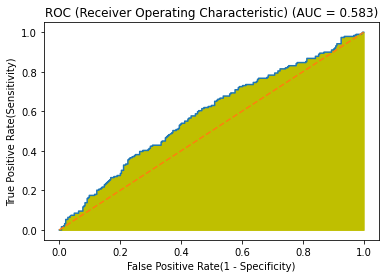

In [84]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict([test_x,test_x1])[:,1]) #곡선 그리기

plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='y')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate(1 - Specificity)')
#plt.xlabel('FPR')
plt.ylabel('True Positive Rate(Sensitivity)')
#'''
score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

plt.title('ROC (Receiver Operating Characteristic) (AUC = {})'.format(round(score,4)))
plt.show()